In [1]:
#Calculate Fisher, Chi2 and G tests between census and F&Y data.
#By James Doherty 17.04.2020

from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels.stats.proportion as smp
from matplotlib.backends.backend_pdf import PdfPages

Saving demographics_survey_and_census.csv to demographics_survey_and_census.csv
Saving withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx to withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
survey_guide_path = 'withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx'

# Create a dictionary of question names
questions_dict = pd.read_excel(survey_guide_path, 'Variables')
questions_dict = pd.Series(questions_dict.Label.values, index=questions_dict.Variable).to_dict()

# Create a nested dictionary of answer names
answers_dict = pd.read_excel(survey_guide_path, 'Values')
answers_dict['Label'] = (answers_dict['Label']
                         .replace({'Wave 1':2010, 'Wave 2':2012, 'Wave 3':2014, 'Wave 4':2016, 'Wave 5':2018})
                         .replace({'Married/Civil Partnership/Living with Partner':'Married/Partnership'})
                         .replace({'Single/Widowed/Divorced/Separated/Other':'Single/Other'}))
answers_dict = answers_dict.fillna(method='ffill')
answers_dict = answers_dict.groupby('Variable')[['Vlue', 'Label']].apply(lambda g: dict(g.values)).to_dict()
answers_dict['wimd_2014_quintile'] = {1: 1, 2: 2, # 1 is most deprived
                                      3: 3, 4: 4, 5: 5, # 5 is least deprived
                                      -8: "Don't know", -1:'Not applicable'}

In [23]:
#Read in data from F&U and deal with null values
data = pd.read_csv('demographics_survey_and_census.csv')
data = pd.DataFrame(data)
data

,Unnamed: 0,Q6_1,RespSex,age_dv,marstat2,religion_dv,source,wimd_2014_quintile,workstat2
0,4,NaN,2,NaN,1.0,1.0,survey,NaN,NaN
1,7,NaN,2,NaN,1.0,1.0,survey,NaN,NaN
2,23,NaN,2,NaN,1.0,1.0,survey,NaN,NaN
3,24,NaN,1,NaN,1.0,1.0,survey,NaN,NaN
4,50,NaN,2,NaN,1.0,1.0,survey,NaN,NaN
...,...,...,...,...,...,...,...,...,...
45488,982092,1.0,1,3.0,2.0,1.0,census,5.0,1.0
45489,982093,1.0,2,3.0,2.0,NaN,census,4.0,1.0
45490,982094,1.0,1,1.0,2.0,3.0,census,5.0,3.0
45491,982095,1.0,2,4.0,1.0,1.0,census,5.0,1.0


source   census  survey
RespSex                
1         21337     664
2         22400    1092
Fisher exact prior odds ratio = 1.567
Fisher exact p-value = 1.243e-19
Chi2 test statistic = 80.937
Chi2 p-value = 2.331e-19
Chi2 degrees of freedom = 1.000
G-test statistic = 81.892
G-test p-value = 1.437e-19
G-test degrees of freedom = 1.000


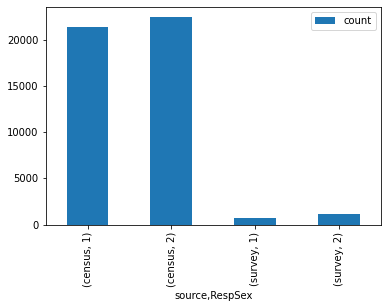

In [43]:
#Calculate Fisher's, Chi2 and G tests for demographics in F&U vs. census 

from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency

# demographic_variables = ['age_dv', 'marstat2', 'religion_dv', 'RespSex', 'wimd_2014_quintile', 'workstat2', 'Q6_1']

#group questions of interest
source = 'source'
main_feature = 'RespSex'
temp = data.groupby([source, main_feature])[main_feature].agg(['count'])
# temp['total'] = temp.groupby('source')['count'].transform('sum')

#quick plot
%matplotlib inline 
temp.plot(kind='bar')

#construct contingency table: must be 2x2
tab = pd.crosstab(data.RespSex, data.source)
tab = tab.iloc[[True, True]] #choose 2 rows
print(tab)

#Fisher exact test
print("Fisher exact prior odds ratio =", '%.3f' % fisher_exact(tab)[0])
print("Fisher exact p-value =", '%.3e' % fisher_exact(tab)[1])

#Chi^2
print("Chi2 test statistic =", '%.3f' % chi2_contingency(tab)[0])
print("Chi2 p-value =", '%.3e' % chi2_contingency(tab)[1])
print("Chi2 degrees of freedom =", '%.3f' % chi2_contingency(tab)[2])
#print("Chi2 expecetd frequencies", '%.3f' % chi2_contingency(tab)[3])

#G-test
print("G-test statistic =", '%.3f' % chi2_contingency(tab, lambda_="log-likelihood")[0])
print("G-test p-value =", '%.3e' % chi2_contingency(tab, lambda_="log-likelihood")[1])
print("G-test degrees of freedom =", '%.3f' % chi2_contingency(tab, lambda_="log-likelihood")[2])
#print("G-test expecetd frequencies", chi2_contingency(tab, lambda_="log-likelihood")[3])

temp.reset_index(inplace=True) # To 'undo' the grouping